# Introduction

This notebook applies the methods of parametrized classification to the Pythia electron-positron scattering dataset (https://zenodo.org/record/3518708). The data for each jet has 7 entries and takes the form $(p_T,\eta,\phi,\text{pID},\theta_1,\theta_2,\theta_3)$. These quantities are defined as follows:
- $p_T$: tranverse momentum of the particle
- $\eta$: pseudorapidity (i.e. the angle of the particle relative to the beam axis)
- $\phi$: azimuthal angle (i.e. the angle in the plane transverse to the beam)
- PID: Particle IDentification (for numbering scheme information see https://pdg.lbl.gov/2007/reviews/montecarlorpp.pdf)
- $\theta_1$: 𝚃𝚒𝚖𝚎𝚂𝚑𝚘𝚠𝚎𝚛:𝚊𝚕𝚙𝚑𝚊𝚂𝚟𝚊𝚕𝚞𝚎 $\in [0.10, 0.18]$ ("effective" strong coupling constant $\alpha_S$)
- $\theta_2$: 𝚂𝚝𝚛𝚒𝚗𝚐𝚉:𝚊𝙻𝚞𝚗𝚍 $\in [0.50, 0.90]$ (Hadronization, determines how partons become hadrons, String model, $Z$)
- $\theta_3$: 𝚂𝚝𝚛𝚒𝚗𝚐𝙵𝚕𝚊𝚟:𝚙𝚛𝚘𝚋𝚂𝚝𝚘𝚄𝙳 $\in [0.10, 0.30]$ (modeling parameters determining Strange behavior)

These $\theta_i$ values are Pythia parameters and were sampled uniformly according to the bounds shown above.

## Imports

In [1]:
import os
import sys
os.environ['KMP_DUPLICATE_LIB_OK']='True'
sys.path.append('/Users/matangrinberg/Library/CloudStorage/GoogleDrive-matan.grinberg@gmail.com/My Drive/(21-24) University of California, Berkeley/ML HEP/parametrized-classifiers/data')

In [2]:
# standard library imports
from __future__ import absolute_import, division, print_function

# standard numerical library imports
import numpy as np
import scipy as sp
import tensorflow as tf
import keras

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split, remap_pids, to_categorical

import matplotlib.pyplot as plt

In [3]:
# Global plot settings
# from matplotlib import rc
# import matplotlib.font_manager
# rc('font', family='serif')
# rc('text', usetex=True)
# rc('font', size=22) 
# rc('xtick', labelsize=15) 
# rc('ytick', labelsize=15) 
# rc('legend', fontsize=15)

# Load Data

## Utilities

In [4]:
# normalize pT and center (y, phi)
def normalize(x):
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()
    
def preprocess_data(X):
    for x in X:
        normalize(x)
    
    # Remap PIDs to unique values in range [0,1], error_on_unknown flag for PIDs not in dictionary
    remap_pids(X, pid_i=3, error_on_unknown=False)
    return X

## Process data

In [5]:
# Path to downloaded data from Zenodo
data_dir = '/Users/matangrinberg/Library/CloudStorage/GoogleDrive-matan.grinberg@gmail.com/My Drive/(21-24) University of California, Berkeley/ML HEP/parametrized-classifiers/data/'

In [6]:
dataset = np.load(data_dir + '1D_alphaS_train.npz')

In [7]:
X = preprocess_data(dataset['X'])
Y = to_categorical(dataset['Y'], num_classes=2)

In [8]:
X.shape

(1800000, 51, 7)

In [9]:
X_train, X_val, Y_train, Y_val = data_split(X, Y, test=0.1)

In [10]:
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)

(1620000, 51, 7)
(1620000, 2)
(180000, 51, 7)
(180000, 2)


In [11]:
print(X_train[0, 0])

[0.02178351 0.51061995 0.37863145 0.1        0.115365   0.68000001
 0.21699999]


# Building/Training Interpolated Model

In [12]:
# network architecture parameters
Phi_sizes = (100,100,128)
F_sizes = (100,100,100)

model_interpolate = PFN(input_dim=7, Phi_sizes=Phi_sizes, F_sizes=F_sizes, summary=False)

2022-12-07 15:01:40.193599: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
save_label = 'DCTR_ee_dijets_1D_alphaS'
checkpoint = keras.callbacks.ModelCheckpoint('./saved_models/' + save_label + '.h5', monitor='val_loss', verbose=2, save_best_only=True, mode='min')
CSVLogger = keras.callbacks.CSVLogger('./logs/' + save_label + '_loss.csv', append=False)
EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, restore_best_weights=True)
callbacks = [checkpoint, CSVLogger, EarlyStopping]

# epochs = 10
epochs = 100
batch_size = 1000

In [18]:
history = model_interpolate.fit(X_train, Y_train,
                    epochs = epochs,
                    batch_size = batch_size,
                    validation_data = (X_val, Y_val),
                    verbose = 1, 
                    callbacks = callbacks)

Epoch 1/100
1620/1620 [==============================] - ETA: 0s - loss: 0.6879 - acc: 0.5373
Epoch 1: val_loss improved from inf to 0.68478, saving model to ./saved_models/DCTR_ee_dijets_1D_alphaS.h5
1620/1620 [==============================] - 89s 55ms/step - loss: 0.6879 - acc: 0.5373 - val_loss: 0.6848 - val_acc: 0.5472
Epoch 2/100
1620/1620 [==============================] - ETA: 0s - loss: 0.6820 - acc: 0.5546
Epoch 2: val_loss improved from 0.68478 to 0.68077, saving model to ./saved_models/DCTR_ee_dijets_1D_alphaS.h5
1620/1620 [==============================] - 84s 52ms/step - loss: 0.6820 - acc: 0.5546 - val_loss: 0.6808 - val_acc: 0.5575
Epoch 3/100
1620/1620 [==============================] - ETA: 0s - loss: 0.6808 - acc: 0.5569
Epoch 3: val_loss did not improve from 0.68077
1620/1620 [==============================] - 82s 51ms/step - loss: 0.6808 - acc: 0.5569 - val_loss: 0.6816 - val_acc: 0.5539
Epoch 4/100
1619/1620 [============================>.] - ETA: 0s - loss: 0.680

## Plot History

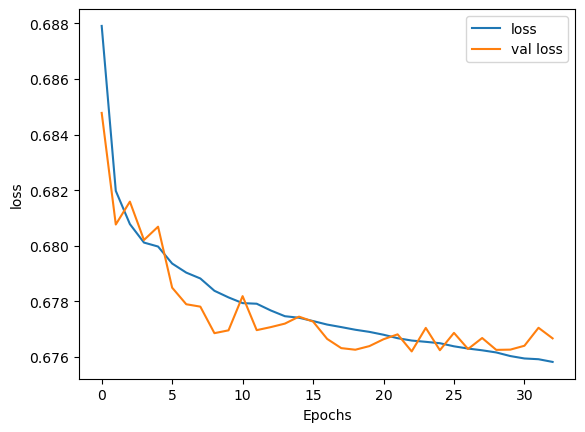

In [19]:
plt.plot(history.history['loss'],     label = 'loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.legend(loc=0)
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.show()

# Load Interpolated Model

In [14]:
# load model from saved file
model_interpolate.model.load_weights('./saved_models/DCTR_ee_dijets_1D_alphaS.h5')

## Load Datasets

In [17]:
test_dataset_0 = np.load(data_dir+'test1D_default.npz')
test_dataset_1 = np.load(data_dir+'test1D_alphaS.npz')

## Get predictions

In [ ]:
# Load test datasets
X0_test = preprocess_data(test_dataset_0['jet'])
X1_test = preprocess_data(test_dataset_1['jet'])

In [20]:
# Get predicted probabilities
preds_0 = dctr.predict(X0_test, batch_size=1000)
preds_1 = dctr.predict(X1_test, batch_size=1000)

## Get weights

In [21]:
weights_0 = preds_0[:,0]/preds_0[:,1]
weights_1 = preds_1[:,0]/preds_1[:,1]

In [25]:
# Define default plot styles
plot_style_0 = {'histtype':'step', 'color':'black', 'linewidth':2, 'linestyle':'--', 'density':True}
plot_style_1 = {'alpha':0.5, 'density':True}

# Fitting

## Parameter-Finder Model

In [54]:
class AddParams2Input(keras.layers.Layer):
    """ Custom layer for tuning parameters: 
    Arguments:
    - n_params : (int) - the number of n_params that are in X_dim
    - default_params : (list of floats) - initial values for each of the parameters
    - trainable_params : (list of booleans) - True for parameters that you want to fit, false for parameters that should be fixed at default value

    Usage: 
    Let X_dim be the input dimension of each particle to a PFN model, and n_params be the number of MC parameters. 
    Defines a Layer that takes in an array of dimension 
    (batch_size, padded_multiplicity, X_dim - n_params)
    This layer appends each particle by the default_params and makes then trainable or non-trainable based on trainable_params
    """
    
    def __init__(self, n_params, default_params, trainable_params):
        super(AddParams2Input, self).__init__()
        # Definitions
        self.n_params = n_params
        self.params = default_params
        self.trainable_params = trainable_params
        self.loss_fn = tf.keras.losses.BinaryCrossentropy()
        self.param_weights = []

    
    def build(self, input_shape):
        # Convert input parameters to weights and make then trainable or non-trainable
        for i in range(self.n_params):
            # Create weight in layer for each parameter, trainable depending on trainable_params (Binary)
            self.param_weights.append(self.add_weight(name='tuning_param_{}'.format(i), shape=(1, 1), initializer=keras.initializers.Constant(self.params[i]), trainable=self.trainable_params[i]))
            
        self.param_weights = keras.backend.concatenate(self.param_weights, axis = -1)
        super(AddParams2Input, self).build(input_shape)
        
        
    def call(self, input):
        # Add MC params to each input particle (but not to the padded rows)
        concat = tf.transpose(keras.backend.tf.where(keras.backend.abs(input[..., 0]) > 0, tf.transpose(self.param_weights * keras.backend.ones_like(input[..., 0:self.n_params])),
                                                                                        tf.transpose(keras.backend.zeros_like(input[..., 0:self.n_params]))))
        return keras.backend.concatenate([input, concat], -1)
        
        
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1] + self.n_params)         

In [55]:
def model_parameter_finder(model_interpolate, X_dim, n_params, default_params, trainable_params):
    """ 
    Get a model that trains on the input parameters
    
    Arguments:
    - model_interpolate : a PFN model that has been trained to continuously interpolate over the input parameter dimensions
    - X_dim : (int) - the dimension of the input expected by DCTR_model
    - n_params : (int) - the number of n_params that are in X_dim
    - default_params : (list of floats) - default values for each of the parameters
    - trainable_params : (list of booleans) - True for parameters that you want to fit, false for parameters that should be fixed at default value

    Returns:
    - model_parameter_finder: a compiled model that gradient descends only on the trainable parameters
    """
    
    # Do sanity checks on inputs
    assert X_dim >=n_params, "X_dim must be larger than n_params. X_dim includes the dimensionality of the 4-vector + number of parameters"
    assert n_params == len(default_params), "Dimension mismatch between n_params and number of default parameters given. len(default_params) must equal n_params"
    assert n_params == len(trainable_params), "Dimension mismatch between n_params and trainable_params. len(trainable_params) must equal n_params."
    assert np.any(trainable_params), "All parameters are set to non-trainable."
    
    # Set all weights in interpolation_model to non-trainable
    for layer in model_interpolate.layers: 
        layer.trainable = False
    
    # Define input to DCTR_fit_model
    raw_inputs = keras.Input(shape=(None, X_dim - n_params), name='pf_input')

    # Construct layer that adds trainable and non-trainable parameters to the input
    add_params_layer = AddParams2Input(n_params, default_params, trainable_params)
    input_for_interp = keras.layers.TimeDistributed(add_params_layer, name='input_for_interpolate')(raw_inputs)
    output = model_interpolate.model(input_for_interp)
    
    # Define full model
    model_parameter_finder = fitmodel = keras.Model(inputs = raw_inputs, outputs = output, name='pf_output')
    optimizer = keras.optimizers.Adam(learning_rate=1e-4)
    
    # Compile with loss function
    # loss_fn = tf.keras.losses.BinaryCrossentropy()
    model_parameter_finder.compile(optimizer=optimizer, loss='categorical_crossentropy')
    # model_parameter_finder.compile(optimizer=optimizer, loss=loss_fn)
    
    return model_parameter_finder

In [52]:
def get_loss(X, Y, model, params, batch_size = 1000):
    model_pf = model_parameter_finder(model, X_dim =7, n_params = 3, default_params = params, trainable_params = [True, False, False])
    return model_pf.evaluate(x=X, y=Y, batch_size=batch_size)

In [56]:
model_interpolate_pf = model_parameter_finder(model_interpolate, X_dim =7, n_params = 3, 
                       default_params   = [0.1365, 0.68, 0.217], # default params for [alpha_s, aLund, StoUD]
                       trainable_params = [True, False, False]) # Only train alpha_s

In [59]:
model_interpolate_pf.summary()

Model: "pf_output"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pf_input (InputLayer)       [(None, None, 4)]         0         
                                                                 
 input_for_interpolate (Time  (None, None, 7)          3         
 Distributed)                                                    
                                                                 
 model (Functional)          (None, 2)                 57130     
                                                                 
Total params: 57,133
Trainable params: 1
Non-trainable params: 57,132
_________________________________________________________________


In [57]:
model_interpolate_pf.layers[1].get_weights()

[array([[0.1365]], dtype=float32),
 array([[0.68]], dtype=float32),
 array([[0.217]], dtype=float32)]

In [60]:
model_interpolate_pf.predict(X_fit[0:1])

1/1 [==============================] - 0s 106ms/step


array([[0.5115007, 0.4884993]], dtype=float32)

In [65]:
weights = [np.array([[1]],   dtype=np.float32),
               np.array([[1]],    dtype=np.float32),
               np.array([[1]], dtype=np.float32)]
model_interpolate_pf.layers[1].set_weights(weights)

In [66]:
model_interpolate_pf.layers[1].get_weights()

[array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32)]

In [67]:
model_interpolate_pf.predict(X_fit[0:1])

1/1 [==============================] - 0s 12ms/step


array([[0.5115007, 0.4884993]], dtype=float32)

## Load Data

In [19]:
default_dataset = np.load(data_dir + 'test1D_default.npz')
unknown_dataset = np.load(data_dir + 'test1D_alphaS.npz')

In [20]:
X_default = preprocess_data(default_dataset['jet'][:,:,:4])
X_unknown = preprocess_data(unknown_dataset['jet'][:,:,:4])
Y_default = np.zeros_like(X_unknown[:,0,0])
Y_unknown = np.ones_like(X_unknown[:,0,0])

In [21]:
X_fit = np.concatenate((X_default, X_unknown), axis = 0)
Y_fit = np.concatenate((Y_default, Y_unknown), axis = 0)
Y_fit = to_categorical(Y_fit, num_classes=2)

In [22]:
X_fit, _, Y_fit, _ = data_split(X_fit, Y_fit, test=0, shuffle=True)

## Evaluate Loss as a function of MC parameter

In [25]:
get_loss(X_fit, Y_fit, model_interpolate, [0.1, 0.68, 0.217])

1800/1800 [==============================] - 37s 20ms/step - loss: 0.7709


0.7708501815795898

In [26]:
alpha_loss = np.array([(a, get_loss(X_fit, Y_fit, model_interpolate, [a, 0.68, 0.217])) for a in np.linspace(0.1,0.18, 31)])

1800/1800 [==============================] - 38s 21ms/step - loss: 0.6814


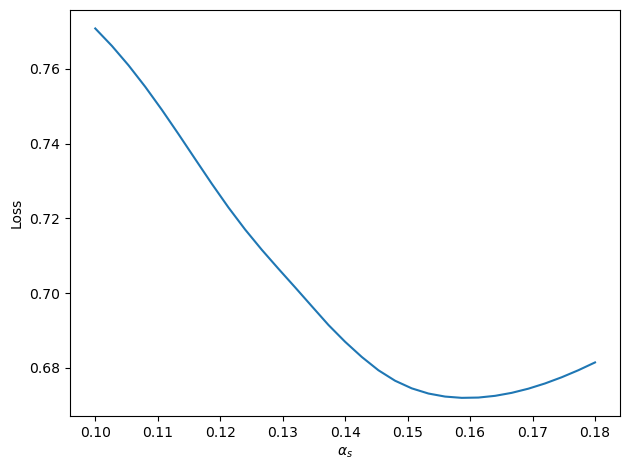

In [27]:
plt.plot(*alpha_loss.T)
plt.ylabel('Loss')
plt.xlabel(r'$\alpha_s$')
# plt.legend()
plt.tight_layout()
plt.show()

In [29]:
def get_min_loss(losses, x0):
    f = sp.interpolate.interp1d(losses[:,0], losses[:,1], fill_value="extrapolate")
    return sp.optimize.minimize(f, x0=x0)['x']

get_min_loss(alpha_loss, x0=0.1365)

array([0.15866666])

## Tune with Gradient Descent

In [35]:
print_weights = keras.callbacks.LambdaCallback(on_epoch_end=lambda batch, logs: print("alpha_s fit = ", model_interpolate_pf.get_weights()[0][0][0]))
fit_vals = [0.1365]
append_weights = keras.callbacks.LambdaCallback(on_epoch_end=lambda batch, logs: fit_vals.append(model_interpolate_pf.get_weights()[0][0][0]))

callbacks = [print_weights, append_weights]

In [41]:
model_interpolate_pf.summary()

Model: "pf_output"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pf_input (InputLayer)       [(None, None, 4)]         0         
                                                                 
 input_for_interpolate (Time  (None, None, 7)          3         
 Distributed)                                                    
                                                                 
 model (Functional)          (None, 2)                 57130     
                                                                 
Total params: 57,133
Trainable params: 1
Non-trainable params: 57,132
_________________________________________________________________


In [40]:
model_interpolate_pf.fit(X_fit, Y_fit, epochs=10, batch_size=10000)

Epoch 1/10


ValueError: in user code:

    File "/opt/anaconda3/envs/pc/lib/python3.10/site-packages/keras/engine/training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "/opt/anaconda3/envs/pc/lib/python3.10/site-packages/keras/engine/training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/anaconda3/envs/pc/lib/python3.10/site-packages/keras/engine/training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "/opt/anaconda3/envs/pc/lib/python3.10/site-packages/keras/engine/training.py", line 893, in train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/anaconda3/envs/pc/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/optimizer_v2.py", line 539, in minimize
        return self.apply_gradients(grads_and_vars, name=name)
    File "/opt/anaconda3/envs/pc/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/optimizer_v2.py", line 640, in apply_gradients
        grads_and_vars = optimizer_utils.filter_empty_gradients(grads_and_vars)
    File "/opt/anaconda3/envs/pc/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/utils.py", line 73, in filter_empty_gradients
        raise ValueError(f"No gradients provided for any variable: {variable}. "

    ValueError: No gradients provided for any variable: (['input_for_interpolate/tuning_param_0:0'],). Provided `grads_and_vars` is ((None, <tf.Variable 'input_for_interpolate/tuning_param_0:0' shape=(1, 1) dtype=float32>),).


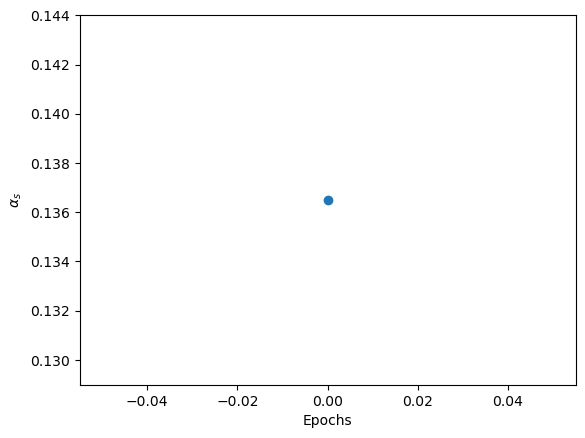

In [33]:
plt.plot(fit_vals, marker='o')
plt.xlabel("Epochs")
plt.ylabel(r'$\alpha_s$')
plt.show()